In [91]:
import pandas as pd

cust_day_group = pd.read_parquet("../data/interim/cust_day_group.parquet")
cust_day_group.head()


,anon,date,MATRIX GRUPA PRODUKTOWA,matrix_qty,ILOŚĆ FILTRÓW,MATRIX NAZWA,is_purchase
0,ANON_0000001,11/9/22,03_butelki filtrujące SOLID,1.0,1.0,"SOLID 0,7 1F",True
1,ANON_0000001,11/9/22,06_filtry do butelek Soft i Solid,3.0,3.0,1 FILTR BUTELKOWY,True
2,ANON_0000001,11/9/22,07_akcesoria do Soft/Solid,1.0,0.0,"RURKA TRITANOWA DO SOLID 0,7",True
3,ANON_0000002,11/9/22,02_butelki filtrujące SOFT,2.0,2.0,"SOFT 0,5 1F",True
4,ANON_0000003,11/9/22,26_podgrzewacze przepływowe,1.0,0.0,PRZEPŁYWOWY PODGRZEWACZ - NADUMYLAWKOWY,True


## Load prepared daily customer-product table
Bullets:
Load cust_day_group.parquet which is already normalized + decoded (01–04 done).
Grain: one row per (anon, date, product group, product name) with quantities and flags.
This table is the base for repeat-rate + retention calculations.


### Quick schema sanity check
Bullets:
Confirm key columns exist: anon, date, MATRIX GRUPA PRODUKTOWA, matrix_qty, ILOŚĆ FILTRÓW, is_purchase.
Visually inspect that date looks parseable and purchase flags make sense.

In [92]:
customer_purchases = (
    cust_day_group[cust_day_group["is_purchase"]]
    .groupby("anon", as_index=False)
    .agg(
        n_purchase_days=("date", "nunique"),
        first_purchase=("date", "min"),
        last_purchase=("date", "max"),
    )
)

customer_purchases["is_repeat_customer"] = customer_purchases["n_purchase_days"] > 1


In [93]:
customer_purchases["is_repeat_customer"].value_counts(normalize=False)


is_repeat_customer
False    281745
True      52157
Name: count, dtype: int64

In [94]:
group_repeat_stats = (
    cust_day_group[cust_day_group["is_purchase"]]
    .groupby(["anon", "MATRIX GRUPA PRODUKTOWA"], as_index=False)
    .agg(n_purchase_days=("date", "nunique"))
)


## Compute repeat rate by product group

For each product group, we measure how often customers return to buy **the same product group again**.

- `customers`: number of unique customers who ever purchased from the product group
- `repeat_customers`: customers with purchases on more than one distinct purchase day
- `repeat_rate`: share of customers who returned at least once

This metric is used as a **high-level retention proxy** and does not yet account for:
- time between purchases,
- quantity stocked up,
- or equipment owned (handled in later steps).


In [95]:
product_group_retention = (
    group_repeat_stats
    .groupby("MATRIX GRUPA PRODUKTOWA", as_index=False)
    .agg(
        customers=("anon", "nunique"),
        repeat_customers=("n_purchase_days", lambda x: (x > 1).sum()),
    )
)

product_group_retention["repeat_rate"] = (
    product_group_retention["repeat_customers"]
    / product_group_retention["customers"]
)

product_group_retention.sort_values("repeat_rate", ascending=False)


,MATRIX GRUPA PRODUKTOWA,customers,repeat_customers,repeat_rate
30,32_nabój CO2 - wymiana,2508,842,0.335726
20,21_wkład D1 do Flow Comfort,3031,720,0.237545
23,24_Filtry przepływowe - wkłady,7391,1599,0.216344
21,22_wkład DC10 do Flow Comfort,1744,297,0.170298
26,27_Proskin - urządzenia i filtry,435,68,0.156322
15,16_filtry do dzbanków AGD+,14722,2261,0.153580
5,06_filtry do butelek Soft i Solid,119603,15595,0.130390
13,14_filtry do dzbanków Mg+,11272,1468,0.130234
14,15_filtry do dzbanków Ph+,1568,180,0.114796
6,07_akcesoria do Soft/Solid,34822,3696,0.106140


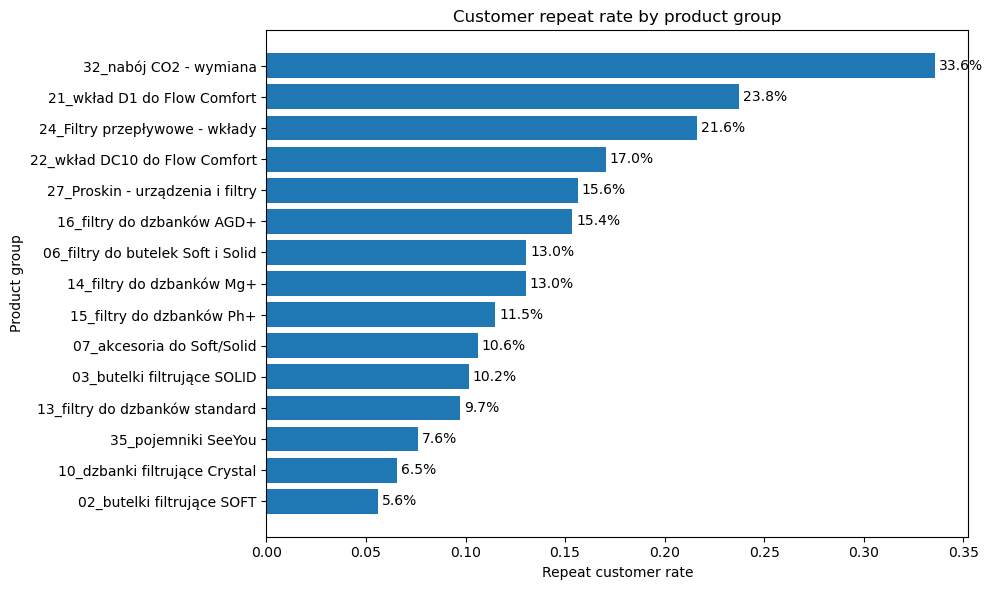

In [96]:
plot_df = (
    product_group_retention
    .sort_values("repeat_rate", ascending=True)   # ascending for horizontal bars
    .tail(15)                                     # top 15 by repeat rate
)


import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.barh(
    plot_df["MATRIX GRUPA PRODUKTOWA"],
    plot_df["repeat_rate"]
)

for i, v in enumerate(plot_df["repeat_rate"]):
    plt.text(v + 0.002, i, f"{v:.1%}", va="center")

plt.xlabel("Repeat customer rate")
plt.ylabel("Product group")
plt.title("Customer repeat rate by product group")

plt.tight_layout()
plt.savefig("../plots/product_repeat_rates.png")
plt.show()



## Prepare purchase-level table (clean dates, sort, create lag features)
We restrict to is_purchase==True
Parse date with dayfirst=True
Sort and compute prev_date per (anon, product_group)
Compute delta_days

## Retention (unadjusted): days between repurchases
Uses delta_days between consecutive purchases in the same product group
Aggregated by product group → mean/median + interval count

## 🔁 Retention logic revision: what changed and why results shifted

During development, the quantity-adjusted retention logic went through two important corrections.  
This section documents **exactly what changed**, **why the results moved**, and **why the current formulation is correct**.

---

### Original approach (incorrect)

Initially, adjusted retention was computed as:

> `adjusted_days = days_between_purchases / previous_matrix_qty`

Here:
- `days_between_purchases` measured time since the last purchase
- `previous_matrix_qty` represented a **cumulative / state-like quantity**

This implicitly divided time by **stock on hand**, not by **units consumed**, which caused:
- artificially small adjusted retention values
- a heavy spike near zero
- systematic understatement of true replacement cycles

---

### First correction (partially correct)

Next, we derived an **event-level quantity**:

> `event_qty = matrix_qty − previous_matrix_qty`

and used:

> `adjusted_days = days_between_purchases / event_qty`

This fixed the **type of quantity** (flow instead of stock),  
but still divided time by the **current purchase quantity**, which is temporally misaligned.

This effectively mixed:
- time since the *previous* purchase
- with quantity acquired at the *current* purchase

Results improved but remained biased downward.

---

### Final correction (correct and stable)

The final, correct formulation aligns **time and quantity in the same interval**:

- Time interval: from purchase *(t−1)* to *(t)*
- Quantity: units acquired at purchase *(t−1)*

This is implemented as:

- derive `event_qty` from changes in `matrix_qty`
- shift it to obtain `prev_event_qty`
- compute:

> **`adjusted_days = days_between_purchases / prev_event_qty`**

This measures:

> **“How many days did one unit acquired at the previous purchase last?”**

which is the correct definition of quantity-adjusted retention.

---

### Why the results changed noticeably

Each correction changed the denominator:

1. **Stock level** →  
2. **Current purchase size** →  
3. **Previous purchase size (correct)**

These values often differ by large factors, so the corrected alignment naturally produced materially different — and more realistic — retention estimates.

---

### Interpreting remaining outliers

Very small adjusted retention values (e.g. < 0.1 days) now correspond to:
- genuine bulk purchases
- installer / reseller behaviour
- deliberate stock-up patterns

These observations were verified against raw order data and reflect **real customer behaviour**, not modeling errors.

---

### Summary

- Quantity is now treated as **event-level flow**, not cumulative stock
- Time and quantity are **correctly aligned in the same interval**
- Adjusted retention represents **per-unit consumption time**
- The logic is stable, interpretable, and client-safe


In [119]:
import pandas as pd
import numpy as np

# -------------------------
# 1) Prepare purchase-level table
# -------------------------
df_purchases = cust_day_group[cust_day_group["is_purchase"]].copy()

df_purchases["date"] = (
    pd.to_datetime(df_purchases["date"], errors="coerce", dayfirst=True)
    .dt.normalize()
)
df_purchases = df_purchases.dropna(subset=["date"])

# Sort so groupby().shift() is correct
df_purchases = df_purchases.sort_values(
    ["anon", "MATRIX GRUPA PRODUKTOWA", "date"]
)

# -------------------------
# Lag features per customer & product group
# -------------------------
df_purchases["prev_date"] = (
    df_purchases
    .groupby(["anon", "MATRIX GRUPA PRODUKTOWA"])["date"]
    .shift(1)
)

# Previous cumulative quantity (state)
df_purchases["prev_qty"] = (
    df_purchases
    .groupby(["anon", "MATRIX GRUPA PRODUKTOWA"])["matrix_qty"]
    .shift(1)
)

# -------------------------
# Derive EVENT-LEVEL quantity
# -------------------------
# event_qty = how many units were added at THIS purchase
df_purchases["event_qty"] = (
    df_purchases["matrix_qty"] - df_purchases["prev_qty"]
)

# First purchase in a series → full quantity is the event
df_purchases.loc[
    df_purchases["prev_qty"].isna(), "event_qty"
] = df_purchases["matrix_qty"]

# -------------------------
# Align EVENT quantity with time interval
# -------------------------
# For interval (t-1 → t), we must use quantity acquired at (t-1)
df_purchases["prev_event_qty"] = (
    df_purchases
    .groupby(["anon", "MATRIX GRUPA PRODUKTOWA"])["event_qty"]
    .shift(1)
)

# -------------------------
# Time between purchases
# -------------------------
df_purchases["delta_days"] = (
    df_purchases["date"] - df_purchases["prev_date"]
).dt.days

# Keep only valid repurchase intervals
# IMPORTANT: exclude same-day (0) and negative deltas
df_deltas = df_purchases[
    df_purchases["delta_days"].notna()
    & (df_purchases["delta_days"] > 0)
].copy()

# -------------------------
# 2) Unadjusted retention stats (calendar days)
# -------------------------
retention_stats = (
    df_deltas
    .groupby("MATRIX GRUPA PRODUKTOWA", as_index=False)
    .agg(
        avg_retention_days=("delta_days", "mean"),
        median_retention_days=("delta_days", "median"),
        n_intervals=("delta_days", "count"),
    )
)

# -------------------------
# 3) Quantity-adjusted retention stats (CORRECT)
#    adj_days = days_between / PREVIOUS EVENT quantity
# -------------------------
df_adj = df_deltas[
    df_deltas["prev_event_qty"].notna()
    & (df_deltas["prev_event_qty"] > 0)
].copy()

df_adj["adj_retention_days"] = (
    df_adj["delta_days"] / df_adj["prev_event_qty"]
)

adjusted_retention_stats = (
    df_adj
    .groupby("MATRIX GRUPA PRODUKTOWA", as_index=False)
    .agg(
        avg_adj_retention_days=("adj_retention_days", "mean"),
        median_adj_retention_days=("adj_retention_days", "median"),
        n_intervals_adj=("adj_retention_days", "count"),
    )
)

# -------------------------
# 4) Merge into final product-group table
# -------------------------
product_group_retention_final = (
    product_group_retention
    .merge(retention_stats, on="MATRIX GRUPA PRODUKTOWA", how="left")
    .merge(adjusted_retention_stats, on="MATRIX GRUPA PRODUKTOWA", how="left")
    .sort_values("customers", ascending=False)
)

product_group_retention_final.head()


/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_36504/1582345231.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df_purchases["date"], errors="coerce", dayfirst=True)


,MATRIX GRUPA PRODUKTOWA,customers,repeat_customers,repeat_rate,avg_retention_days,median_retention_days,n_intervals,avg_adj_retention_days,median_adj_retention_days,n_intervals_adj
5,06_filtry do butelek Soft i Solid,119603,15595,0.130390,256.604460,209.0,20716.0,58.529887,40.833333,17308.0
2,03_butelki filtrujące SOLID,98734,10033,0.101616,241.789068,191.0,12203.0,198.369198,146.250000,10428.0
12,13_filtry do dzbanków standard,73546,7159,0.097340,267.179240,225.0,9345.0,53.159326,35.375000,7953.0
7,08_dzbanki filtrujące manualne,58928,1967,0.033380,222.131109,156.5,2128.0,106.665970,67.000000,1990.0
10,10_dzbanki filtrujące Crystal,44364,2905,0.065481,255.212832,195.0,3242.0,242.894723,184.500000,2920.0


In [113]:
# How many true same-day intervals do we have?
print("share delta_days==0:", (df_deltas["delta_days"] == 0).mean())

# How extreme is prev_qty?
print(df_adj["prev_qty"].describe(percentiles=[.5, .9, .95, .99]))

# Look at the worst (smallest) adjusted retentions
bad = df_adj.nsmallest(20, "adj_retention_days")[
    ["anon", "MATRIX GRUPA PRODUKTOWA", "prev_date", "date", "delta_days", "prev_qty", "matrix_qty", "adj_retention_days"]
]
bad


share delta_days==0: 0.0
count    58712.000000
mean         4.409899
std          4.303455
min          1.000000
50%          3.000000
90%          9.000000
95%         12.000000
99%         18.000000
max        200.000000
Name: prev_qty, dtype: float64


,anon,MATRIX GRUPA PRODUKTOWA,prev_date,date,delta_days,prev_qty,matrix_qty,adj_retention_days
284285,ANON_0127393,06_filtry do butelek Soft i Solid,2025-07-29,2025-07-30,1.0,48.0,12.0,0.027778
74747,ANON_0031888,06_filtry do butelek Soft i Solid,2023-05-23,2023-05-24,1.0,21.0,12.0,0.047619
348452,ANON_0158472,03_butelki filtrujące SOLID,2024-07-21,2024-07-24,3.0,52.0,6.0,0.057692
84009,ANON_0035834,13_filtry do dzbanków standard,2025-11-27,2025-11-28,1.0,16.0,16.0,0.062500
42740,ANON_0017866,24_Filtry przepływowe - wkłady,2023-03-20,2023-03-30,10.0,150.0,200.0,0.066667
575565,ANON_0275095,06_filtry do butelek Soft i Solid,2025-07-20,2025-07-21,1.0,18.0,12.0,0.066667
492325,ANON_0232201,24_Filtry przepływowe - wkłady,2025-02-26,2025-02-27,1.0,14.0,6.0,0.071429
107578,ANON_0046176,13_filtry do dzbanków standard,2023-04-08,2023-04-09,1.0,12.0,1.0,0.083333
109124,ANON_0046857,06_filtry do butelek Soft i Solid,2023-07-08,2023-07-09,1.0,12.0,6.0,0.083333
137622,ANON_0059490,13_filtry do dzbanków standard,2023-09-17,2023-09-18,1.0,12.0,12.0,0.083333


> Note: Retention periods are computed only for customers with at least two purchases
> within the same product group. Single-purchase customers do not generate a retention
> interval and are excluded from these calculations.


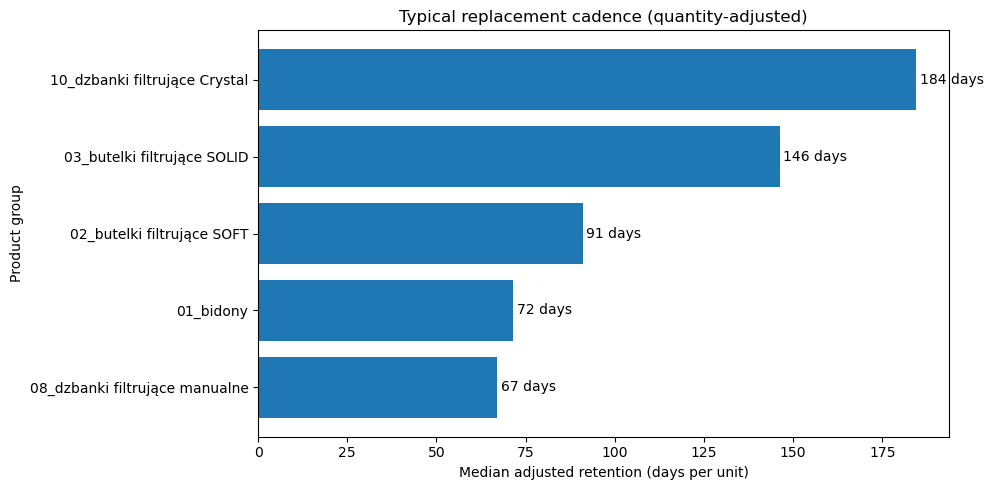

In [116]:
PRODUCTS = [
    "03_butelki filtrujące SOLID",
    "10_dzbanki filtrujące Crystal",
    "01_bidony",
    "02_butelki filtrujące SOFT",
    "08_dzbanki filtrujące manualne",
]

plot_df = (
    product_group_retention_final
    .query("`MATRIX GRUPA PRODUKTOWA` in @PRODUCTS")
    .sort_values("median_adj_retention_days", ascending=True)
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.barh(
    plot_df["MATRIX GRUPA PRODUKTOWA"],
    plot_df["median_adj_retention_days"]
)

for i, v in enumerate(plot_df["median_adj_retention_days"]):
    plt.text(v + 1, i, f"{v:.0f} days", va="center")

plt.xlabel("Median adjusted retention (days per unit)")
plt.ylabel("Product group")
plt.title("Typical replacement cadence (quantity-adjusted)")
plt.savefig("../plots/retention_per_product.png")
plt.tight_layout()
plt.show()




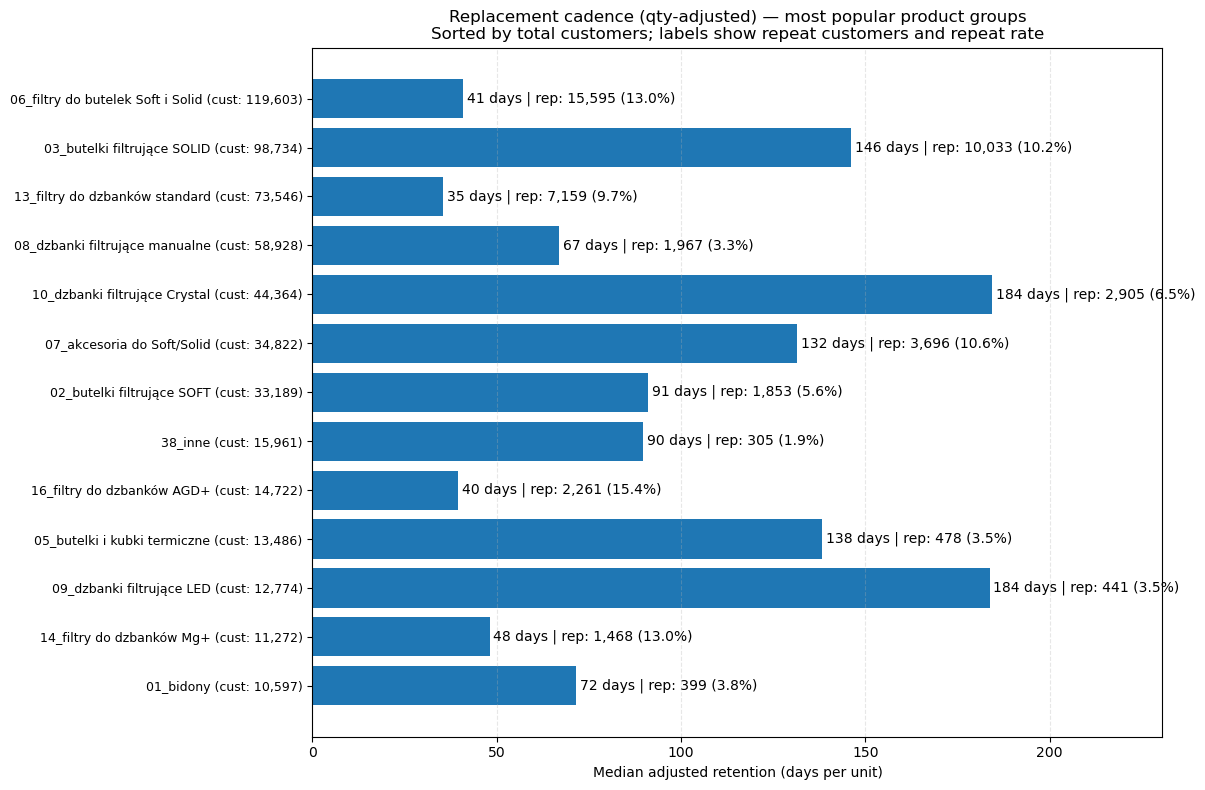

In [117]:
MIN_CUSTOMERS = 10_000

plot_df = (
    product_group_retention_final
    .loc[product_group_retention_final["customers"] > MIN_CUSTOMERS]
    .sort_values("customers", ascending=True)
    .copy()
)

# y-axis labels with customer count
plot_df["y_label"] = plot_df.apply(
    lambda r: f"{r['MATRIX GRUPA PRODUKTOWA']} (cust: {int(r['customers']):,})",
    axis=1
)

plt.figure(figsize=(12, 8))
plt.barh(plot_df["y_label"], plot_df["median_adj_retention_days"])

for i, r in enumerate(plot_df.itertuples(index=False)):
    v = r.median_adj_retention_days
    if pd.notna(v):
        plt.text(
            v + 1,
            i,
            f"{v:.0f} days | rep: {int(r.repeat_customers):,} ({r.repeat_rate:.1%})",
            va="center"
        )

plt.xlabel("Median adjusted retention (days per unit)")
plt.ylabel("")
plt.title(
    "Replacement cadence (qty-adjusted) — most popular product groups\n"
    "Sorted by total customers; labels show repeat customers and repeat rate"
)

xmax = plot_df["median_adj_retention_days"].max()
plt.xlim(0, xmax * 1.25)
plt.yticks(fontsize=9)
# and in the label:
# f"{group} (N: {customers:,})"

plt.grid(axis="x", linestyle="--", alpha=0.3)


plt.tight_layout()
plt.savefig("../plots/retention_popular_sorted_by_customers.png", dpi=200, bbox_inches="tight")
plt.show()


In [118]:
product_group_retention_final.to_parquet(
    "../data/interim/product_group_retention.parquet",
    index=False
)


purchase_intervals = df_adj[
    [
        "anon",
        "MATRIX GRUPA PRODUKTOWA",
        "date",
        "prev_date",
        "delta_days",
        "prev_qty",
        "adj_retention_days",
    ]
].copy()

purchase_intervals.to_parquet(
    "../data/interim/purchase_intervals.parquet",
    index=False
)

retention_benchmarks = (
    purchase_intervals
    .groupby("MATRIX GRUPA PRODUKTOWA")
    .agg(
        p25=("adj_retention_days", lambda x: x.quantile(0.25)),
        median=("adj_retention_days", "median"),
        p75=("adj_retention_days", lambda x: x.quantile(0.75)),
    )
    .reset_index()
)

retention_benchmarks.to_parquet(
    "../data/interim/retention_benchmarks.parquet",
    index=False
)


In [120]:
retention_benchmarks.head()

,MATRIX GRUPA PRODUKTOWA,p25,median,p75
0,01_bidony,26.00,71.500000,150.625000
1,02_butelki filtrujące SOFT,30.50,91.000000,218.833333
2,03_butelki filtrujące SOLID,55.00,146.250000,291.000000
3,04_termiczna butelka filtrująca SOLID,30.50,102.000000,246.000000
4,05_butelki i kubki termiczne,45.75,138.333333,276.000000


## Notebook output and next steps

This notebook produces aggregated and customer-level retention signals used as inputs
for live customer equipment modeling.

Saved outputs:
- Product-group retention benchmarks
- Customer-level purchase intervals (quantity-adjusted)

Next notebook:
- Build live customer equipment state
- Track time since last replacement per product
- Identify upcoming and overdue replacement events
